Colab: Implement simclr using Tensorflow

1.Save the model weights
2. Load the models weights and do Linear projections in Imagenet dataset
3. Visualization of the representations

Imagenet dataset consist of 5 classes with 200 images for each class.


## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
!nvidia-smi

Sun Sep 26 01:18:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     | 10.4 MB 834 kB/s
     |████████████████████████████████| 180 kB 5.3 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 139 kB 43.7 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 70 kB 7.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=b3b859ea3f770d240be1610e5ebd0c74886f8e5679973937b2599aabdf6fde14
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=78f916867c17f108f1c372ee10496078196aba0687fc0fe52f5ac7c114308f3e
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=03d0e45fb287444526742a37731b6

In [4]:
pip install wandb --upgrade

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=000998c987a11a662ba1ea6b80427cde92a8d68c01d50ba2fac88f0588b0f022
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: wandb
    Found existing installation: wandb 0.8.36
    Uninstalling wandb-0.8.36:
      Successfully uninstalled wandb-0.8.36


In [5]:
#Login weight abd bias site to run the model
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm


# Random seed fixation
tf.random.set_seed(500)
np.random.seed(500)

## Dataset gathering and preparation

In [7]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 35.76 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [8]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


In [9]:
train_images[0]

'imagenet-5-categories/train/cat_1973374961_28d50cffa2.jpg'

In [10]:
#Defining Custom Augmentation
#AUgmenttaion included Random Flipping, Color Jitter and Color Dropping
class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample
    def _random_apply(self, func, x, p):
        return tf.cond(tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),tf.cast(p, tf.float32)),lambda: func(x),lambda: x)

    def _color_jitter(self, x, s=1):
        
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
   

In [11]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [12]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [22]:
# Create TensorFlow dataset
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Utilities

In [23]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [24]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2021-09-26 01:26:29--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py.1’

helpers.py.1        100%[===================>]     891  --.-KB/s    in 0s      

2021-09-26 01:26:29 (42.0 MB/s) - ‘helpers.py.1’ saved [891/891]

--2021-09-26 01:26:29--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘l

Comment the `augmentation` import in the `helpers.py` script as we are not using gaussian blur for Augmentation Purpose

In [25]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [26]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [27]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [28]:
wandb.init(project="simclr")

In [30]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=50):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        wandb.log({"nt_xentloss": np.mean(step_wise_loss)})
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

Training with 50 epochs due to resource constraints

## Training

  2%|▏         | 1/50 [01:13<59:41, 73.09s/it]

epoch: 1 loss: 4.128


 22%|██▏       | 11/50 [10:25<35:59, 55.36s/it]

epoch: 11 loss: 3.110


 42%|████▏     | 21/50 [19:37<26:41, 55.22s/it]

epoch: 21 loss: 2.475


 62%|██████▏   | 31/50 [28:50<17:30, 55.28s/it]

epoch: 31 loss: 2.104


 82%|████████▏ | 41/50 [38:02<08:16, 55.22s/it]

epoch: 41 loss: 1.899


100%|██████████| 50/50 [46:19<00:00, 55.58s/it]


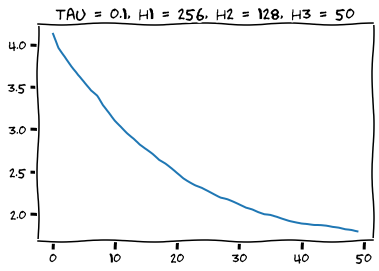

In [31]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=50)

with plt.xkcd():
  
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

## Store the weights to a safe place :)

In [32]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [33]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "simclr.h5"
filename

'20210926-024254simclr.h5'

####Saving model weights

In [34]:
resnet_simclr.save_weights(filename)
wandb.save(filename)

['/content/wandb/run-20210926_012637-30zrmm29/files/20210926-024254simclr.h5']

## Linear Projections of the saved model 





Restoring the weights from wandb

In [41]:
simclr_weights = wandb.restore("20210926-024254simclr.h5", run_path="tamanna/simclr/30zrmm29")

In [42]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [43]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

Loading Test images

In [46]:
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(test_images))

250


In [47]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 125/125 [00:00<00:00, 189.81it/s]


(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 181.82it/s]


(250, 224, 224, 3) (250,)


In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [51]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0   

In [52]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [53]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [54]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0   

In [55]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [56]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
2/2 [==============================] - 1s 256ms/step - loss: 6.7604 - accuracy: 0.1760 - val_loss: 6.7635 - val_accuracy: 0.1960
Epoch 2/35
2/2 [==============================] - 0s 32ms/step - loss: 6.1736 - accuracy: 0.1680 - val_loss: 6.2229 - val_accuracy: 0.1920
Epoch 3/35
2/2 [==============================] - 0s 47ms/step - loss: 5.6502 - accuracy: 0.1440 - val_loss: 5.7271 - val_accuracy: 0.1760
Epoch 4/35
2/2 [==============================] - 0s 34ms/step - loss: 5.1947 - accuracy: 0.1520 - val_loss: 5.2767 - val_accuracy: 0.1600
Epoch 5/35
2/2 [==============================] - 0s 51ms/step - loss: 4.7618 - accuracy: 0.2000 - val_loss: 4.8803 - val_accuracy: 0.1360
Epoch 6/35
2/2 [==============================] - 0s 32ms/step - loss: 4.4015 - accuracy: 0.2080 - val_loss: 4.5382 - val_accuracy: 0.1400
Epoch 7/35
2/2 [==============================] - 0s 36ms/step - loss: 4.1006 - accuracy: 0.1760 - val_loss: 4.2497 - val_accuracy: 0.1600
Epoch 8/35
2/2 [==========

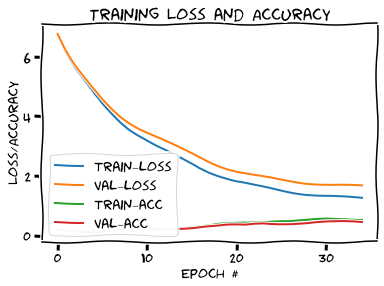

In [58]:
# Linear model
from wandb.keras import WandbCallback
wandb.init(project="simclr", id="linear-eval-relu-last")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [59]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


accuracy,0.536
best_epoch,34
best_val_loss,1.65528
epoch,34
loss,1.24578
val_accuracy,0.46
val_loss,1.65528


accuracy,▂▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▅▅▅▅▆▆▆▇██████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▂▂▂▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▅▆▇▇▇▇▇▇██████
val_loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


Epoch 1/35
2/2 [==============================] - 1s 224ms/step - loss: 5.0155 - accuracy: 0.1600 - val_loss: 4.5410 - val_accuracy: 0.2120
Epoch 2/35
2/2 [==============================] - 0s 39ms/step - loss: 4.2815 - accuracy: 0.2080 - val_loss: 3.8833 - val_accuracy: 0.2520
Epoch 3/35
2/2 [==============================] - 0s 41ms/step - loss: 3.7112 - accuracy: 0.2240 - val_loss: 3.3962 - val_accuracy: 0.2520
Epoch 4/35
2/2 [==============================] - 0s 34ms/step - loss: 3.2412 - accuracy: 0.2400 - val_loss: 3.1027 - val_accuracy: 0.2680
Epoch 5/35
2/2 [==============================] - 0s 34ms/step - loss: 2.9602 - accuracy: 0.2800 - val_loss: 2.9573 - val_accuracy: 0.2880
Epoch 6/35
2/2 [==============================] - 0s 38ms/step - loss: 2.8220 - accuracy: 0.3040 - val_loss: 2.8542 - val_accuracy: 0.3000
Epoch 7/35
2/2 [==============================] - 0s 41ms/step - loss: 2.6904 - accuracy: 0.3200 - val_loss: 2.7159 - val_accuracy: 0.3200
Epoch 8/35
2/2 [==========

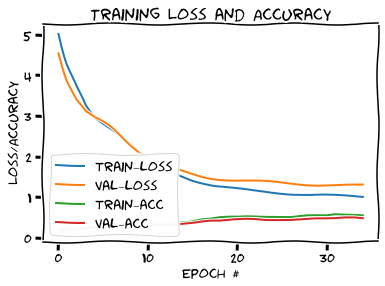

In [60]:
wandb.init(project="simclr", id="linear-eval-relu-second-last")

linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [61]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


accuracy,0.576
best_epoch,34
best_val_loss,1.29157
epoch,34
loss,1.01279
val_accuracy,0.492
val_loss,1.29157


accuracy,▁▂▂▂▃▃▄▄▅▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██▇▇████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▂▃▃▄▄▃▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇██▇▇▇███
val_loss,█▇▆▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Epoch 1/35
2/2 [==============================] - 1s 224ms/step - loss: 2.3257 - accuracy: 0.2640 - val_loss: 1.8219 - val_accuracy: 0.2840
Epoch 2/35
2/2 [==============================] - 0s 42ms/step - loss: 1.9899 - accuracy: 0.2240 - val_loss: 1.6971 - val_accuracy: 0.4360
Epoch 3/35
2/2 [==============================] - 0s 49ms/step - loss: 1.5672 - accuracy: 0.4800 - val_loss: 1.4502 - val_accuracy: 0.3920
Epoch 4/35
2/2 [==============================] - 0s 34ms/step - loss: 1.3846 - accuracy: 0.4480 - val_loss: 1.4158 - val_accuracy: 0.4080
Epoch 5/35
2/2 [==============================] - 0s 47ms/step - loss: 1.2636 - accuracy: 0.4880 - val_loss: 1.2308 - val_accuracy: 0.5120
Epoch 6/35
2/2 [==============================] - 0s 35ms/step - loss: 1.1359 - accuracy: 0.5120 - val_loss: 1.1900 - val_accuracy: 0.5280
Epoch 7/35
2/2 [==============================] - 0s 40ms/step - loss: 1.0856 - accuracy: 0.5280 - val_loss: 1.1656 - val_accuracy: 0.5600
Epoch 8/35
2/2 [==========

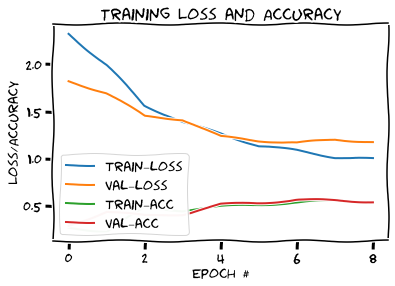

In [62]:
wandb.init(project="simclr", id="linear-eval-no-projections")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

###Visualization of Representation

In [63]:
wandb.init(project="simclr", id="visualization")

accuracy,0.536
best_epoch,6
best_val_loss,1.16558
epoch,8
loss,0.99419
val_accuracy,0.54
val_loss,1.1762


accuracy,▂▁▆▆▇▇▇██
epoch,▁▂▃▄▅▅▆▇█
loss,█▆▄▃▂▂▁▁▁
val_accuracy,▁▅▄▄▇▇██▇
val_loss,█▇▄▄▂▁▁▁▁


In [64]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


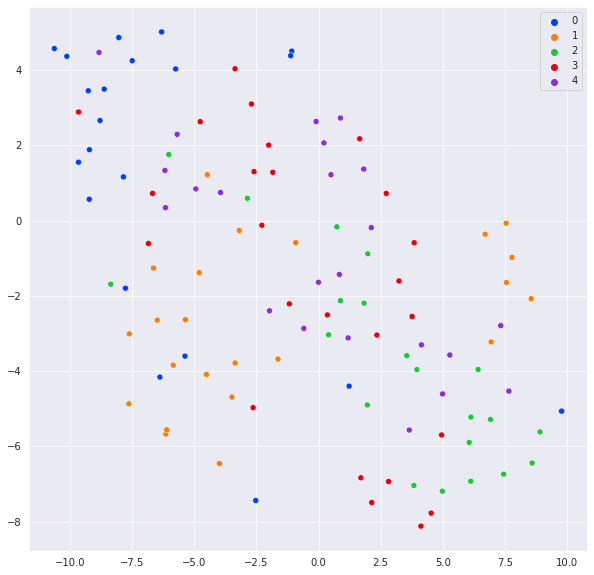

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [67]:
# Representations with no nonlinear projections
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"no_no_linear_projection": fig})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



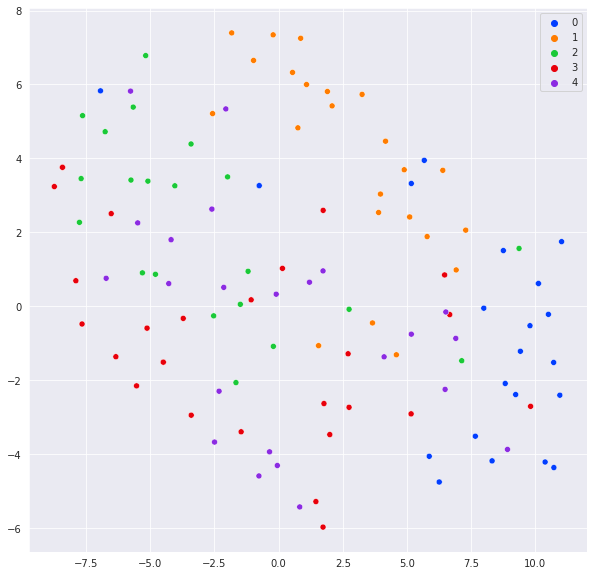

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [68]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"last_relu": fig})